# Task: Wifi Positioning with RSSI Fingerprints
You will get a dataset that was gathered by the Minodes team to enable wifi positioning. In this store we installed 145 of our sensors, also called **nodes**. 

As you walk through the store your phone searches for available wifi networks, by sending probe requests (see 802.11 standard). A part of this probe request is the received signal strength indication (**RSSI**), which has a range between 0db (very strong signal) and -100db (very weak signal). Depending on the distance of your phone to a sensor, the **RSSI** has a different value. In an ideal case one probe request would be perceived by all nodes of the store with different signal strength. In our data processing we collect all this probe requests and aggregate them, so that we have all **RSSI** values for all nodes of one probe request available:

A data set might look like this:


|  ID             | RSSI value node 1 | RSSI value node 2  | .... | RSSI value node n  | fr_zone_id |
| -------------   |-------------      | -----              | -----| -------------------| ------- |
| 1               |-70                | -70                | .... |  -70               | 1       |
| 2               |-55                | -60                | .... |  -45               | 2       |
| 2               |-60                | -60                | .... |  -45               | 2       |
| ...             |.......            | ....               | .... | ....               | ..      |

Each line of this the table is called a fingerprint, which gives us an indication about the potential location of a person.

To locate a person within the store, we separate the store into zones representing compartments of a store. For each of this **zones** we collect reference data, which is stored in the file *training_set.csv* of this exercise.

The goal of this task is to use machine learning techniques to predict the correct zones, based on **RSSI** fingerprints. At the end of this task you need to predict the zones of unkown **RSSI** fingerprints stored in the file *test_without_target.csv*. 

Since we at Minodes love to code, we have done some preparation work, so you can focus on the machine learning.

In case you have any questions please contact **alexander.mueller@minodes.com**

## Remarks

* Please use python 3.x
* I suggest using an anaconda python distribution https://www.continuum.io/downloads
* The code is tested in python 3.4
* Please use pre-existing libraries

## Requirements
The current versions of:
* pandas 
* numpy

## Some imports and a preprocessing routine

In [2]:
%matplotlib inline

import ast
import time
import random
from math import *
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn import neighbors, tree, svm, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, fbeta_score,classification_report,precision_score, accuracy_score, mean_absolute_error, hamming_loss, make_scorer

def preprocess_x_values(x_raw_values):
    """
    A simple preprocessing routine returning a feature vector for the specific fingerprint. 
    """

    v = DictVectorizer(sparse=False)
    
    return v.fit_transform(x_raw_values)

### Loading the data

In [3]:
training_set = pd.read_csv('training_set.csv')

In [4]:
# Load training data

# Parse dictionary of features
training_set['values'] =training_set['values'].apply(lambda x:  ast.literal_eval(x))

# preparing x and y sets 
# x are the features of the set
# y is the class to be predicted
x_raw = training_set['values']
y = training_set['fr_zone_id']

# preprocess the node dictionary to get feature vectors
x_features= preprocess_x_values(x_raw)

In [4]:
x_features.shape

(63134, 137)

In [5]:
x_features

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., -75., -71., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ..., -75.,   0., -78.],
       [-54., -58., -50., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

### Implementation

Think about how you validate your model (based on accuracy), what classifier you want to use and how in the end you want to scorce the test set.

You need to add only a couple of lines of code to have a basic solution. Do this first and then iterate on it.

#### Exploring & processing the dataset

Observations: 
- High dimensionality(lots of features and maybe not all relevant)
- Too many labels to predict
- Lots of 0 values

Provided labelled dataset is divided into training and validation data.This way all avaliable data is grouped into:
- Training data (50%)
- Validation data (25%)
- Test data (25%) - unlabelled

Dimensionality reduction: 
- Feature extraction: N/A (Principal component analysis - not useful, the components are barely correlating with the selected relevant features probably due to lack of linearity.)
- Feature selection: 
	- Features: received signal strength indication (RSSI) of wifi nodes (137)
	- Labels: Compartments of store (96)

In [5]:
#train vs validation set
x_train, x_valid, y_train, y_valid = train_test_split(x_features, y,  test_size=1/3, shuffle=True, random_state=20)
x_train.shape[0]+x_valid.shape[0]

63134

In [ ]:
plt.hist(y_train, bins='auto')

(array([   64.,     0.,    57.,    64.,     7.,     0.,     0.,   293.,
            0.,     0.,     0.,   841.,  1566.,   432.,     0.,     0.,
         1084.,     0.,     0.,     0.,     0.,   944.,     0.,   868.,
         1987.,     0.,     0.,     0.,     0.,     0.,   352.,     0.,
            0.,   813.,     0.,     0.,     0.,  1493.,  1429.,  1323.,
         1469.,  1350.,  1328.,  1432.,  1317.,  1240.,  1131.,  1330.,
         1579.,  2390.,  1127.,  1150.,  1129.,  1264.,  1648.,  2307.,
         1907.,  1672.,  1726.,  1659.,  1567.,  2625.,  1356.,  1319.,
         1174.,  1155.,  1323.,  1446.,  1339.,  1143.,  1439.,  1136.,
         1221.,  1119.]),
 array([  19.        ,   21.08108108,   23.16216216,   25.24324324,
          27.32432432,   29.40540541,   31.48648649,   33.56756757,
          35.64864865,   37.72972973,   39.81081081,   41.89189189,
          43.97297297,   46.05405405,   48.13513514,   50.21621622,
          52.2972973 ,   54.37837838,   56.45945946,  

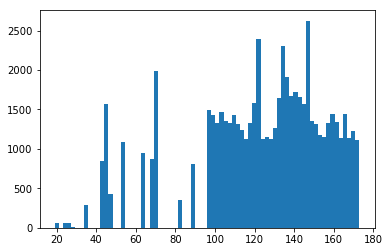

In [5]:
#  number of unique zones, distribution of classes
z = np.unique(y)
#visualization: histogram of zone_id
plt.hist(y, bins='auto')

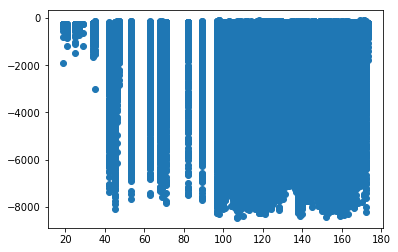

In [6]:
#visualization cont'd: aggregated RSSI for each location
z = np.sum(x_train, axis=1)
plt.scatter(y_train,z)

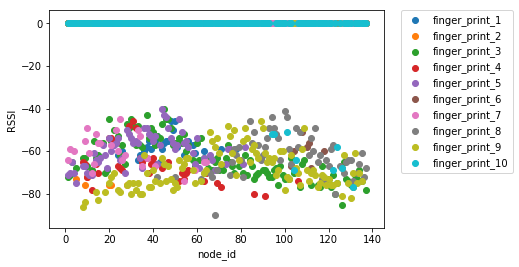

In [14]:
#visualization cont'd: scatter plot of first 10 fingerprints (wifi_node, RSSI)
finger_prints = []
for i in range(1,11):
    finger_prints.append("finger_print_"+str(i))
    plt.scatter(np.arange(1,x_train[i].size+1,1), x_train[i])
plt.xlabel('node_id')
plt.ylabel('RSSI')


plt.legend(finger_prints, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

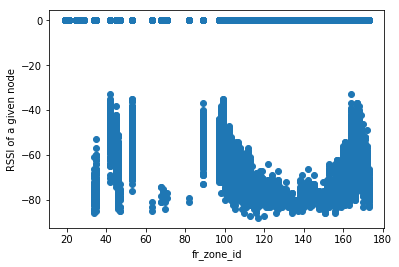

In [8]:
#visualization cont'd: scatter plot of RSSI of one node with zone ids
plt.scatter(y_train.values, x_train[:,2])
plt.xlabel('fr_zone_id')
plt.ylabel('RSSI of a given node')

Explained variance ratio: [ 0.30276857  0.17861406]


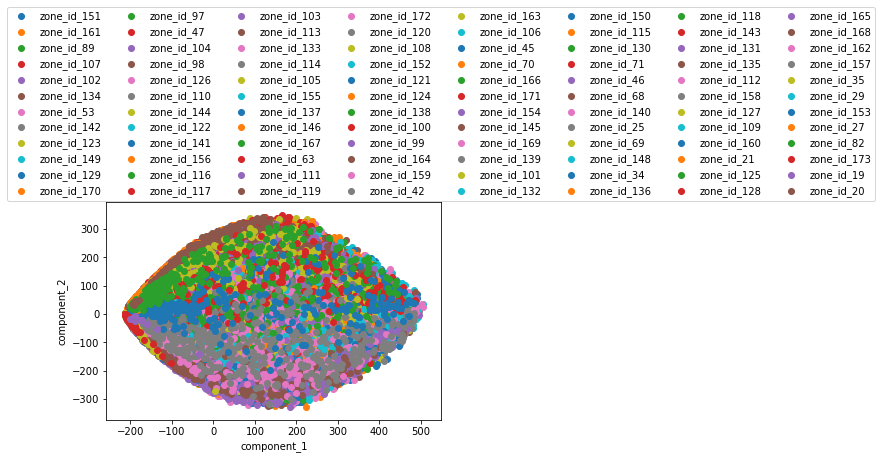

In [42]:
#visualization cont'd
pca = PCA(n_components=2)
X_red = pca.fit(x_train).transform(x_train)
print('Explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))
target_names = y_train.unique()
plt.figure()
for target_name in target_names:
    plt.scatter(X_red[y_train == target_name, 0], X_red[y_train == target_name, 1],
                label=target_name)
plt.xlabel('component_1')
plt.ylabel('component_2')
prefix = 'zone_id_'
labels = [prefix+str(name) for name in target_names]
plt.legend(labels, bbox_to_anchor=(1, 1.9),loc=9, borderaxespad=0., ncol=8)

In [23]:
#dimensionality reduction with PCA -  not really useful due to lack of linearity
pca = PCA(n_components=4)
X_red = pca.fit(x_train).transform(x_train)

target_names = y_train.unique()
# Percentage of variance explained for each components
print('Explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))
# Percentage of total variance explained
print('Total explained: %s'
      % str(sum(pca.explained_variance_ratio_)))
# Components
#print('Components: %s'
#      % str(pca.components_))

Explained variance ratio: [ 0.30276857  0.17861406  0.04888223  0.02355765]
Total explained: 0.553822509724


#### Model training
Potential prediction techniques: 
Naive Bayesian, Nearest neighbour calssification, Decision trees, random forest, SVM (and Neural networks, deep learning techniques)

Some drawbacks of the above different models:
- Since naive Bayes assumes independence between features, it is not used in this problem. 
- The class distribution is skewed so the kNN classification might be biased. 
- Decision trees can be too complex for large datasets and thus not generalizing well, and they are not very robust. 
- The problem with SVM models is that they tend to break down a multiclass classification to binary classification problems, which in this case is not too scaleable and also SVM can be subject to overfitting. 

#### Hyper-parameter tuning
Due to high dimensionality and large number of labels cross-validation is needed to avoid overfitting. F1 score and accuracy were used as scores to find best hyper-parameters.

Grid search with RandomizedSearchCV for faster computation.

In [14]:
scores ={'beta' :make_scorer(fbeta_score, beta=1, average='micro'), 'acc' : 'accuracy'}

In [15]:
#decision tree learning

params_tree = {"splitter": ["best","random"],
              "max_depth": [3, None],
              "max_features": randint(1, 50),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
start_time = time.time()
dtree = tree.DecisionTreeClassifier(random_state=42, class_weight='balanced')
clf_tree = RandomizedSearchCV(estimator=dtree, param_distributions=params_tree, n_iter=20, scoring=scores, cv=5, n_jobs=-1, refit='beta')
clf_tree = clf_tree.fit(x_train, y_train)
pred_tree = clf_tree.predict(x_valid)
probs_tree = clf_tree.predict_proba(x_valid)
elapsed_time = time.time() - start_time
print("Elapsed time for decision tree: " + str(elapsed_time))
clf_tree.best_params_

Elapsed time for decision tree: 20.014586925506592


{'criterion': 'gini',
 'max_depth': None,
 'max_features': 45,
 'min_samples_leaf': 3,
 'splitter': 'best'}

In [17]:
#random forest - random search
params_forest = {"n_estimators": randint(5,100),
              "max_depth": [3, None],
              "max_features": randint(1, 50),
              "min_samples_split": randint(2, 30),
              "min_samples_leaf": randint(1, 30),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
start_time = time.time()
forest = RandomForestClassifier()
clf_forest = RandomizedSearchCV(estimator=forest, param_distributions=params_forest, scoring=scores, cv=5, n_iter=20, n_jobs=-1, refit='beta')
clf_forest = clf_forest.fit(x_train, y_train)
pred_forest = clf_forest.predict(x_valid)
probs_forest = clf_forest.predict_proba(x_valid)
elapsed_time = time.time() - start_time
print("Elapsed time of random forest: " + str(elapsed_time))
clf_forest.best_params_

Elapsed time of random forest: 647.0952951908112


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 32,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 52}

In [21]:
#knn 
k_neighbors=15
start_time = time.time()
clf_knn = neighbors.KNeighborsClassifier(k_neighbors, weights='distance', algorithm='kd_tree', leaf_size=35, p=1, n_jobs=-1)
clf_knn = clf_knn.fit(x_train, y_train)
pred_knn = clf_knn.predict(x_valid)
elapsed_time = time.time() - start_time
print("Elapsed time for knn: " + str(elapsed_time))
#probs_knn = clf_knn.predict_proba(x_valid)

Elapsed time for knn: 144.17409873008728


In [20]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x_train)
#SVM (could not use SVC() or LinearSVC())http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
params_svm = {"loss": ['hinge','log', 'perceptron'],
              "alpha": [0.0001, 0.01, 0.1],
              "penalty": ['l1','l2', 'elasticnet'],
              "power_t" : [0.1,1,1.5,3]}
start_time = time.time()
svc = linear_model.SGDClassifier(random_state=42, class_weight='balanced')
clf_svm = RandomizedSearchCV(estimator=svc, param_distributions=params_svm, scoring=scores,n_iter=20, cv=5, n_jobs=-1, refit='beta')
clf_svm = clf_svm.fit(x_scale, y_train)
elapsed_time = time.time() - start_time
print("Elapsed time for SVM: " + str(elapsed_time))
pred_svm = clf_svm.predict(x_valid)
clf_svm.best_params_

/home/julcsi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Elapsed time for SVM: 556.6410505771637


{'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1', 'power_t': 3}

#### Model selection
Model validation metrics: accuracy, precision, f1 score, recall, Matthews correlation coefficient

Accuracy alone is not necesseraly enough when the data is not balanced, like in this case (see histogram of y). Therefore recall, precision and f1 scores are also used. Since these 3 only care for positive labels, Matthews correlation coefficient is also used. 

From the different algorithms random forest stands out in terms of all metrics. The accuracy is still only around 70%, but if we consider that the number of unique classes is around 90, it is a reasonable number.

##### Chosen model with parameter set:
Random Forest with beta refit (0.71 accuracy)found with RandomizedSearchCV:


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 34,
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 84}


In [22]:
#validation report(precision, recall, f1, support)
cr_tree = classification_report(y_valid, pred_tree)
cr_forest = classification_report(y_valid, pred_forest)
cr_knn = classification_report(y_valid, pred_knn)
cr_svm = classification_report(y_valid, pred_svm)

reports = [cr_tree, cr_forest, cr_knn, cr_svm]
for report in reports:    
    print(report)

             precision    recall  f1-score   support

         19       0.31      0.80      0.44         5
         20       0.12      0.50      0.20         2
         21       0.17      0.71      0.27         7
         25       0.41      0.44      0.43        27
         27       0.33      0.50      0.40        24
         29       0.00      0.00      0.00         2
         34       0.32      0.43      0.37        44
         35       0.34      0.43      0.38        56
         42       0.83      0.70      0.76       298
         45       0.83      0.72      0.77       290
         46       0.93      0.88      0.90       238
         47       0.86      0.85      0.85       145
         53       0.65      0.54      0.59       392
         63       0.31      0.27      0.29       323
         68       0.24      0.23      0.23       278
         69       0.36      0.52      0.43       168
         70       0.36      0.44      0.40       233
         71       0.43      0.45      0.44   

/home/julcsi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
#accuracy
acs_tree = accuracy_score(y_valid, pred_tree)
acs_forest = accuracy_score(y_valid, pred_forest)
acs_knn = accuracy_score(y_valid, pred_knn)
acs_svm = accuracy_score(y_valid, pred_svm)

acses = [acs_tree, acs_forest, acs_knn, acs_svm]
for acs in acses:    
    print(acs)


0.435827987646
0.699073414113
0.571727251129
0.248277500594


In [25]:
#Matthews correlation coefficient
mcc_tree = matthews_corrcoef(y_valid, pred_tree)
mcc_forest = matthews_corrcoef(y_valid, pred_forest)
mcc_knn = matthews_corrcoef(y_valid, pred_knn)
mcc_svm = matthews_corrcoef(y_valid, pred_svm)

mccs = [mcc_tree, mcc_forest, mcc_knn, mcc_svm]
for mcc in mccs:    
    print(mcc)

0.429212834844
0.695390053769
0.566449494173
0.246919873003


### Predict and unkown dataset

In [28]:
test_set = pd.read_csv('test_without_target.csv',index_col='id')
test_set['values'] = test_set['values'].apply(lambda x:  ast.literal_eval(x))
x_test= preprocess_x_values(test_set['values'])

In [32]:
# {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 34, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 84}

best_forest = RandomForestClassifier(bootstrap=False, criterion='gini', max_features=34, min_samples_leaf=6, min_samples_split=10, n_estimators=84)
clf_best_forest = best_forest.fit(x_train, y_train)

In [34]:
pred_best_forest = clf_best_forest.predict(x_test)
probs__best_forest = clf_best_forest.predict_proba(x_test)

### Submit your solution
Please zip the complete folder with your solution and send it back to **alexander.mueller@minodes.com**. We will review it as soon as possible and will come back to you!